In [204]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import xgboost as gb
import sklearn as sk
import sklearn.datasets
import sklearn.svm
import sklearn.ensemble
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score

from plotnine import *

### Load data

In [162]:
iris = sk.datasets.load_iris()
feature_names = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size = 0.3, random_state=1334
)

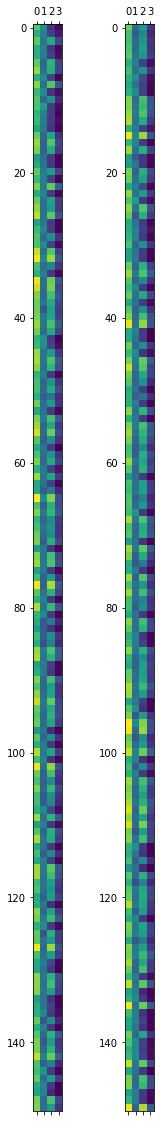

In [112]:
idx = list(range(iris.data.shape[0]))
np.random.shuffle(idx)

fig, ax = pl.subplots(1, 2, figsize=(3, 20))
ax[0].matshow(iris.data)
ax[1].matshow(iris.data[idx, ])
pl.show()

### Train model

In [190]:
svc = sk.svm.SVC(kernel='rbf')
svc.fit(X_train, y_train)

rfc = sk.ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

gb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 3,
}
dtrain = gb.core.DMatrix(X_train, label = y_train, feature_names = feature_names)
gbc = gb.train(gb_params, dtrain)

### Test prediction

In [196]:
print(iris.target_names)

pred_test_svc = svc.predict(X_test)
print(sk.metrics.confusion_matrix(y_test, pred_test_svc))

['setosa' 'versicolor' 'virginica']
[[17  0  0]
 [ 0 16  0]
 [ 0  0 12]]


In [197]:
pred_test_rfc = rfc.predict(X_test)
print(sk.metrics.confusion_matrix(y_test, pred_test_rfc))

[[17  0  0]
 [ 0 16  0]
 [ 0  0 12]]


In [198]:
pred_test_gb = gbc.predict(gb.core.DMatrix(X_test, feature_names = feature_names))
print(sk.metrics.confusion_matrix(y_test, pred_test_gb))

[[17  0  0]
 [ 0 16  0]
 [ 0  0 12]]


### Cross-validation

In [228]:
svc_cv = cross_val_score(svc, X_train, y_train, cv=10, scoring='f1_micro')
svc_cv

array([1.        , 0.72727273, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.9       , 0.9       ])

In [229]:
rfc_cv = cross_val_score(rfc, X_train, y_train, cv=10, scoring='f1_micro')
rfc_cv

array([1.        , 0.72727273, 1.        , 1.        , 0.81818182,
       1.        , 0.9       , 1.        , 0.9       , 0.8       ])

In [230]:
gbc0 = gb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', num_class=3, use_label_encoder=False)
gbc_cv = cross_val_score(gbc0, X_train, y_train, cv=10, scoring='f1_micro')
gbc_cv

array([1.        , 0.72727273, 0.90909091, 0.90909091, 0.90909091,
       1.        , 0.9       , 1.        , 0.9       , 0.8       ])

In [231]:
cv_df = pd.concat([
    pd.DataFrame({'f1_micro': svc_cv, 'classifier': 'SVM'}),
    pd.DataFrame({'f1_micro': rfc_cv, 'classifier': 'RandomForeset'}),
    pd.DataFrame({'f1_micro': gbc_cv, 'classifier': 'GradientBoostedTree'}),
])
cv_df

,f1_micro,classifier
0,1.000000,SVM
1,0.727273,SVM
2,1.000000,SVM
3,1.000000,SVM
4,1.000000,SVM
5,1.000000,SVM
6,1.000000,SVM
7,1.000000,SVM
8,0.900000,SVM
9,0.900000,SVM


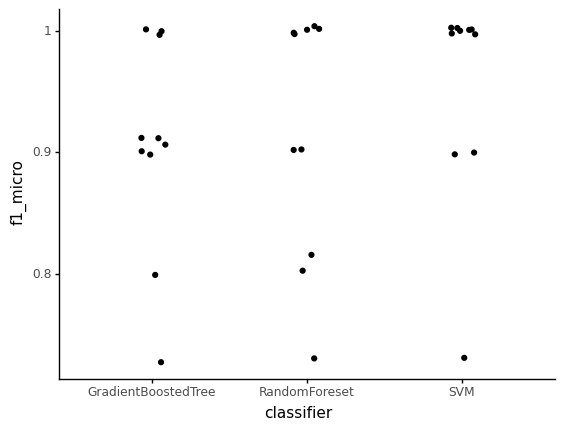

In [232]:
print(
    ggplot(cv_df, aes(x = 'classifier', y = 'f1_micro')) +
        theme_classic() +
        geom_jitter(width=0.1)
)

In [305]:
#def logit(x):
#    return np.log(x) - np.log(1 - x)

#def logistic(x):
#    return 1 / (1 + np.exp(-x))

from scipy.special import logit, expit

pd.DataFrame({
    'x': cv_df['f1_micro'],
    'logit_x': logit(cv_df['f1_micro']),
    'logistic_logit_x': logistic(logit(cv_df['f1_micro'])),
})

,x,logit_x,logistic_logit_x
0,1.000000,inf,1.000000
1,0.727273,0.980829,0.727273
2,1.000000,inf,1.000000
3,1.000000,inf,1.000000
4,1.000000,inf,1.000000
5,1.000000,inf,1.000000
6,1.000000,inf,1.000000
7,1.000000,inf,1.000000
8,0.900000,2.197225,0.900000
9,0.900000,2.197225,0.900000


In [336]:
cv_df.groupby('classifier').describe()

f1_micro                                          \
                       count      mean       std       min       25%   
classifier                                                             
GradientBoostedTree     10.0  0.905455  0.088056  0.727273  0.900000   
RandomForeset           10.0  0.914545  0.102422  0.727273  0.838636   
SVM                     10.0  0.952727  0.089463  0.727273  0.925000   

                                              
                          50%       75%  max  
classifier                                    
GradientBoostedTree  0.909091  0.977273  1.0  
RandomForeset        0.950000  1.000000  1.0  
SVM                  1.000000  1.000000  1.0

In [342]:
cv_dfg = cv_df.groupby('classifier')
cv_sm_df = pd.DataFrame({
    'mean': cv_dfg.f1_micro.apply(np.mean),
    'sd': cv_dfg.f1_micro.apply(np.std),
    'lmean': cv_dfg.f1_micro.apply(lambda x: np.mean(np.log(x))),
    'lsd': cv_dfg.f1_micro.apply(lambda x: np.std(np.log(x))),
})
#cv_sm_df['lower'] = np.maximum(0, np.exp(cv_sm_df['lmean'] - (1.96 * cv_sm_df['lsd'])))
#cv_sm_df['upper'] = np.minimum(1, np.exp(cv_sm_df['lmean'] + (1.96 * cv_sm_df['lsd'])))
cv_sm_df['lower'] = cv_sm_df['mean'] - (1.96 * cv_sm_df['sd'])
cv_sm_df['upper'] = cv_sm_df['mean'] + (1.96 * cv_sm_df['sd'])
cv_sm_df['classifier'] = cv_sm_df.index
cv_sm_df

,mean,sd,lmean,lsd,lower,upper,classifier
classifier,,,,,,,
GradientBoostedTree,0.905455,0.083537,-0.103825,0.096366,0.741721,1.069188,GradientBoostedTree
RandomForeset,0.914545,0.097166,-0.095299,0.110841,0.724099,1.104992,RandomForeset
SVM,0.952727,0.084872,-0.052917,0.097781,0.786378,1.119077,SVM


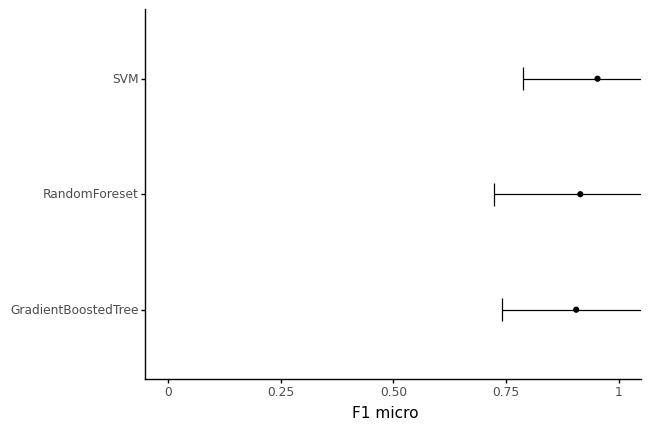

In [347]:
print(
    ggplot(cv_sm_df, aes(x = 'classifier', y = 'mean', ymin = 'lower', ymax='upper')) +
        theme_classic() +
        geom_point() + geom_errorbar(width=0.2) +
        coord_flip(ylim=(0, 1)) +
        ylab('F1 micro') + xlab('')
)

### Complete prediction

In [233]:
pred = svc.predict(iris.data)
#pred = rfc.predict(iris.data)
#pred = np.array(gbc.predict(gb.core.DMatrix(iris.data, feature_names = feature_names))).astype(int)

print(sk.metrics.confusion_matrix(iris.target, pred))

[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]


### Visualize

#### Features

In [235]:
iris_wide = pd.DataFrame(iris.data)
iris_wide.columns = feature_names
iris_wide['target'] = pd.Categorical(iris.target)
iris_wide.target.cat.categories = iris.target_names
iris_wide

,SepalLength,SepalWidth,PetalLength,PetalWidth,target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [236]:
iris_long = iris_wide.melt(id_vars = ['target'])
iris_long

,target,variable,value
0,setosa,SepalLength,5.1
1,setosa,SepalLength,4.9
2,setosa,SepalLength,4.7
3,setosa,SepalLength,4.6
4,setosa,SepalLength,5.0
...,...,...,...
595,virginica,PetalWidth,2.3
596,virginica,PetalWidth,1.9
597,virginica,PetalWidth,2.0
598,virginica,PetalWidth,2.3


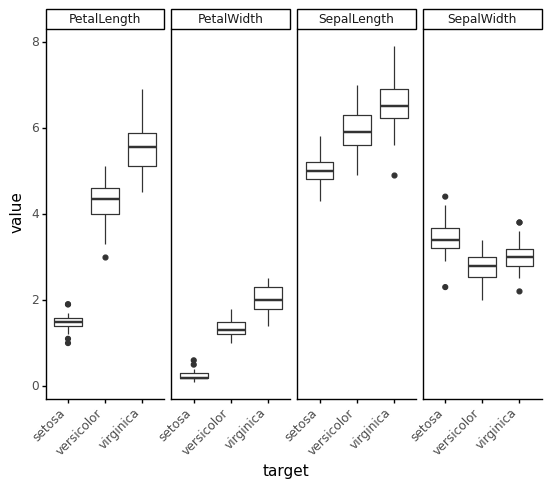

In [237]:
print(
    ggplot(iris_long, aes(x='target', y='value')) +
        theme_classic() +
        facet_grid('. ~ variable') +
        geom_boxplot() +
        theme(axis_text_x = element_text(angle = 45, hjust=1))
)

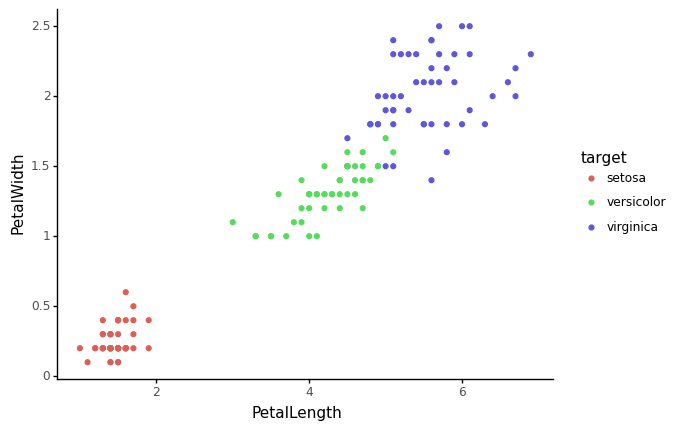

In [44]:
print(
    ggplot(iris_wide, aes(x='PetalLength', y='PetalWidth', colour='target')) +
        theme_classic() +
        geom_point()
)

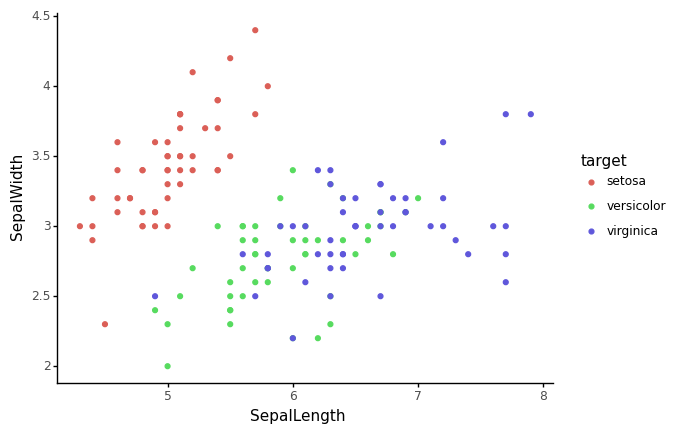

In [47]:
print(
    ggplot(iris_wide, aes(x='SepalLength', y='SepalWidth', colour='target')) +
        theme_classic() +
        geom_point()
)

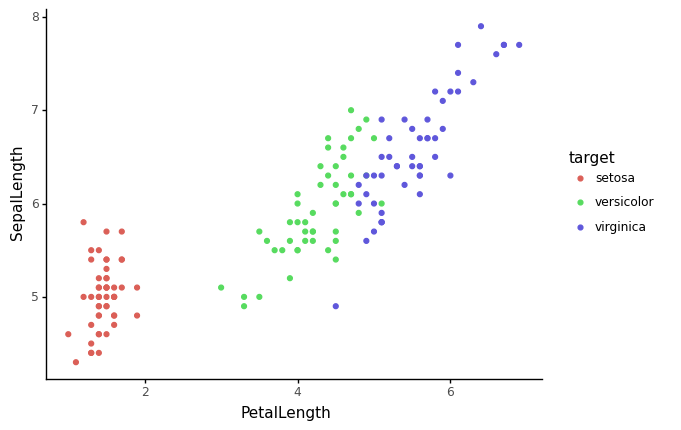

In [171]:
print(
    ggplot(iris_wide, aes(x='PetalLength', y='SepalLength', colour='target')) +
        theme_classic() +
        geom_point()
)

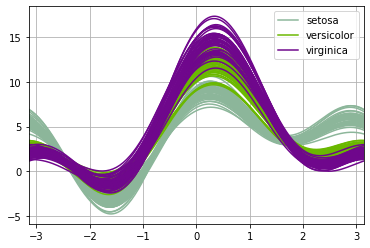

In [170]:
pd.plotting.andrews_curves(iris_wide, 'target')
pl.show()

#### PCA

In [6]:
K = 4
print(iris.data.shape)
pca = PCA(n_components=K)
pca.fit(iris.data.T)

(150, 4)


PCA(n_components=4)

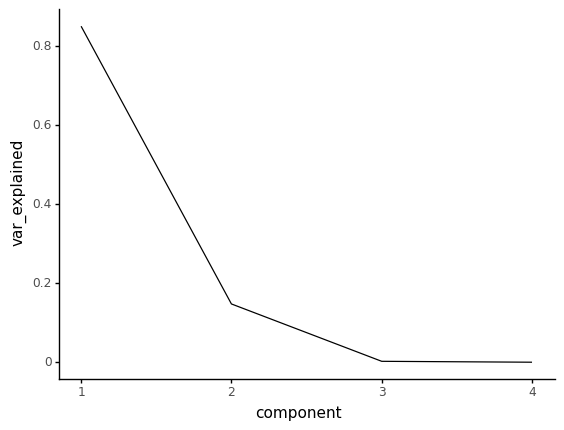

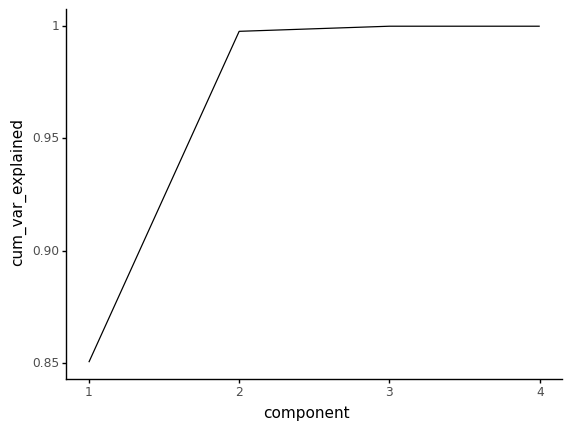

,component,var_explained,cum_var_explained
0,1,8.502577e-01,0.850258
1,2,1.474629e-01,0.997721
2,3,2.279398e-03,1.000000
3,4,2.698723e-32,1.000000


In [7]:
df = pd.DataFrame(
    {
        'component': list(range(1, pca.n_components_+1)),
        'var_explained': pca.explained_variance_ratio_,
        'cum_var_explained': np.cumsum(pca.explained_variance_ratio_)
    }
)
print(
    ggplot(df, aes(x='component', y='var_explained')) + theme_classic() +
        geom_line()
)
print(
    ggplot(df, aes(x='component', y='cum_var_explained')) + theme_classic() +
        geom_line()
)
df

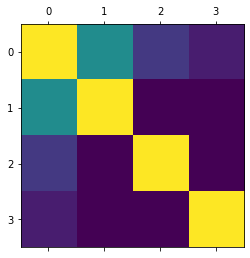

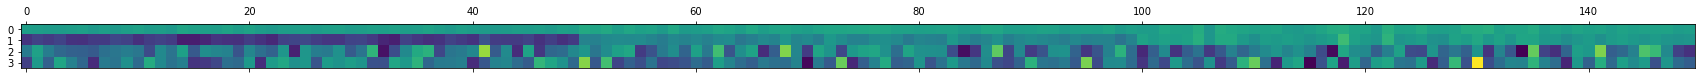

In [238]:
pca_C = np.corrcoef(pca.components_)
pl.matshow(pca_C)
pl.show()

_, ax = pl.subplots(1, 1, figsize=(30, 10))
ax.matshow(pca.components_)
pl.show()

In [239]:
print(pca.components_.T.shape)

df = pd.DataFrame(
    pca.components_.T,
    columns = ['pc{}'.format(k+1) for k in range(pca.n_components_)]
)
df = pd.concat(
    [
        df,
        pd.DataFrame({
            'truth': iris.target_names[iris.target],
            'prediction': iris.target_names[pred],
        }),
        iris_wide,
    ],
    axis = 1
)
df['disconcordant'] = df['truth'] != df['prediction']
df

(150, 4)


,pc1,pc2,pc3,pc4,truth,prediction,SepalLength,SepalWidth,PetalLength,PetalWidth,target,disconcordant
0,0.077146,-0.120972,0.003266,-0.102384,setosa,setosa,5.1,3.5,1.4,0.2,setosa,False
1,0.075365,-0.099515,0.082362,0.066201,setosa,setosa,4.9,3.0,1.4,0.2,setosa,False
2,0.070947,-0.109971,0.011014,-0.044533,setosa,setosa,4.7,3.2,1.3,0.2,setosa,False
3,0.070060,-0.096781,-0.031240,0.090420,setosa,setosa,4.6,3.1,1.5,0.2,setosa,False
4,0.075065,-0.124100,-0.043600,0.017085,setosa,setosa,5.0,3.6,1.4,0.2,setosa,False
...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.081651,0.057513,0.153792,0.071197,virginica,virginica,6.7,3.0,5.2,2.3,virginica,False
146,0.082505,0.069871,0.133714,-0.076892,virginica,virginica,6.3,2.5,5.0,1.9,virginica,False
147,0.083141,0.057404,0.034747,0.057293,virginica,virginica,6.5,3.0,5.2,2.0,virginica,False
148,0.072100,0.054232,-0.100616,-0.024608,virginica,virginica,6.2,3.4,5.4,2.3,virginica,False


In [240]:
def _pca_plot(dim1, dim2):
    return (
        ggplot(df,
            aes(x = dim1, y = dim2,
                fill='truth', colour='prediction',
                shape='disconcordant'
               )) + 
        theme_classic() +
        geom_point() +
        guides(colour=False)
    )

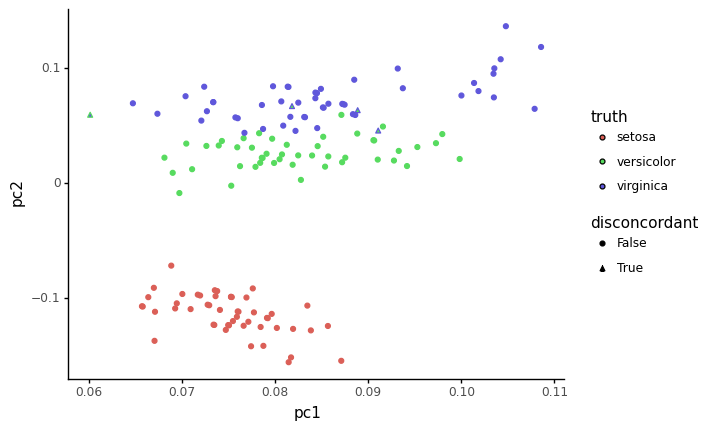

In [241]:
print(_pca_plot('pc1', 'pc2'))

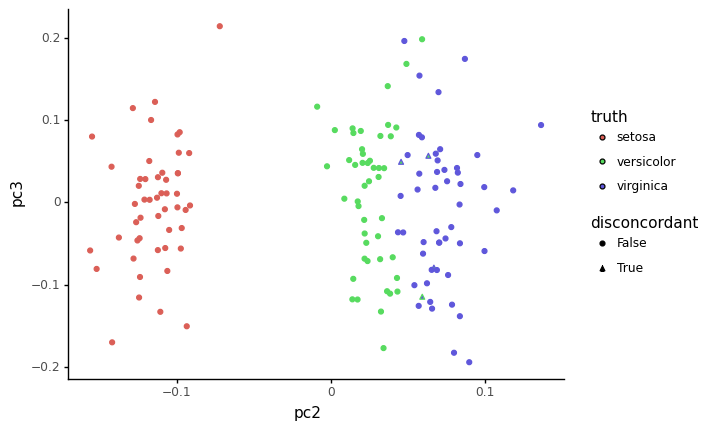

In [242]:
print(_pca_plot('pc2', 'pc3'))

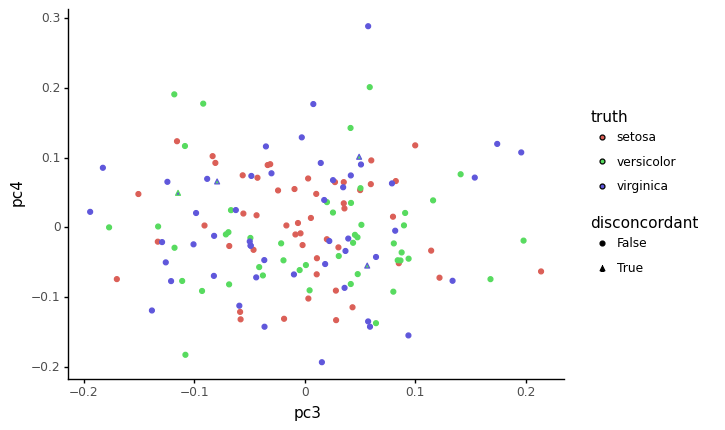

In [243]:
print(_pca_plot('pc3', 'pc4'))

PC2 appears to be highly predictive of flower class. Let us determine what it represents.

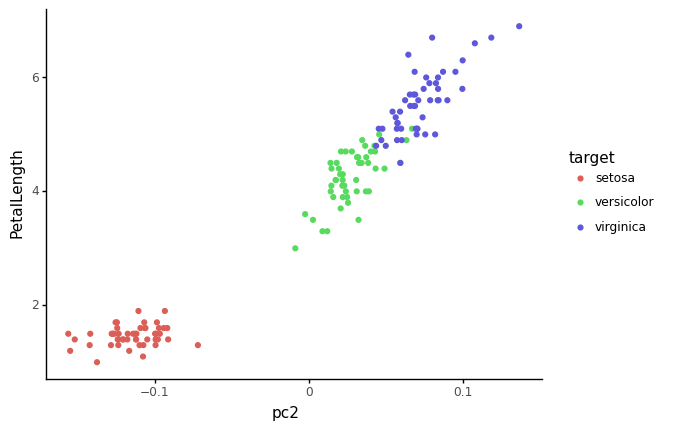

In [244]:
print(
    ggplot(df, aes(x='pc2', y='PetalLength', colour='target')) +
        theme_classic() +
        geom_point()
)

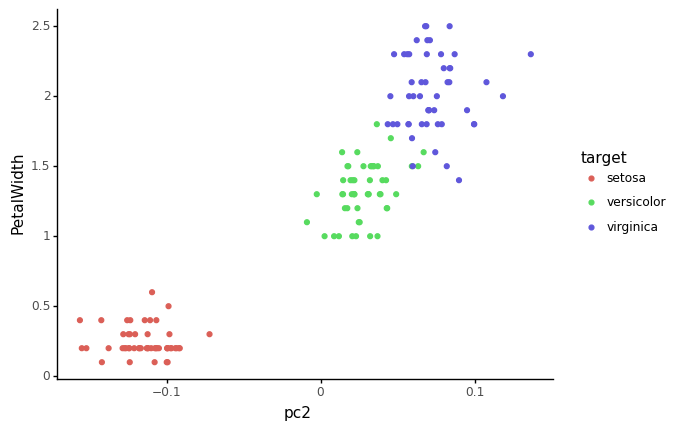

In [245]:
print(
    ggplot(df, aes(x='pc2', y='PetalWidth', colour='target')) +
        theme_classic() +
        geom_point()
)

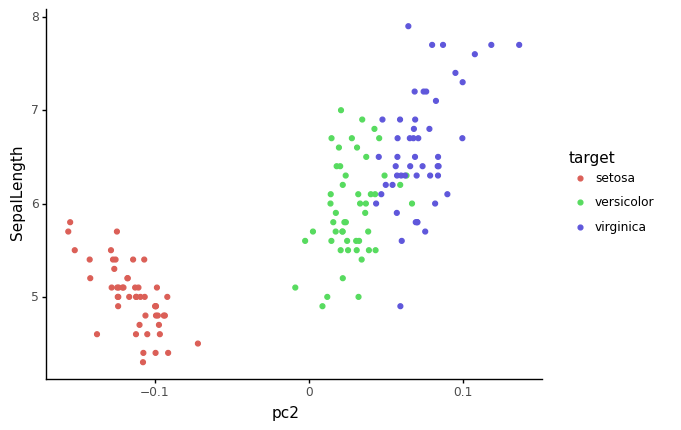

In [246]:
print(
    ggplot(df, aes(x='pc2', y='SepalLength', colour='target')) +
        theme_classic() +
        geom_point()
)

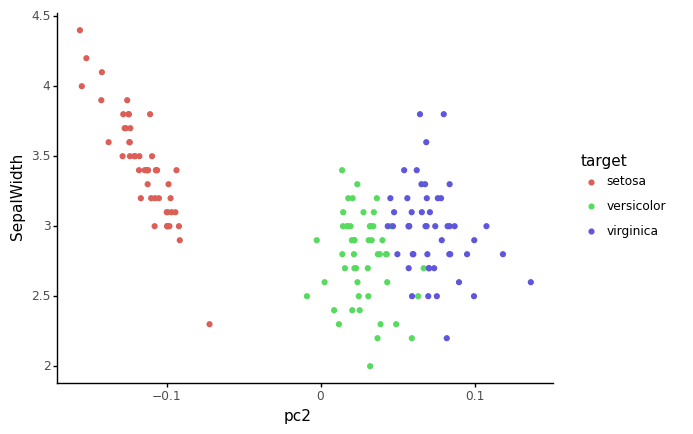

In [247]:
print(
    ggplot(df, aes(x='pc2', y='SepalWidth', colour='target')) +
        theme_classic() +
        geom_point()
)

#### TSNE

In [251]:
tsne = TSNE(learning_rate='auto', init='pca', perplexity=50)
tsne.fit(iris.data)

/Users/dshih/local/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.


TSNE(init='pca', learning_rate='auto', perplexity=50)

In [254]:
tsne_df = pd.concat(
    [
        pd.DataFrame(tsne.embedding_, columns=['d1', 'd2']),
        iris_wide,
        pd.DataFrame({'prediction': iris.target_names[pred]}),
    ],
    axis = 1
)
tsne_df

,d1,d2,SepalLength,SepalWidth,PetalLength,PetalWidth,target,prediction
0,-11.691800,1.398048,5.1,3.5,1.4,0.2,setosa,setosa
1,-10.863805,0.922821,4.9,3.0,1.4,0.2,setosa,setosa
2,-11.037152,1.523923,4.7,3.2,1.3,0.2,setosa,setosa
3,-10.772846,1.204191,4.6,3.1,1.5,0.2,setosa,setosa
4,-11.706921,1.505213,5.0,3.6,1.4,0.2,setosa,setosa
...,...,...,...,...,...,...,...,...
145,8.620135,-0.636772,6.7,3.0,5.2,2.3,virginica,virginica
146,7.268285,0.036677,6.3,2.5,5.0,1.9,virginica,virginica
147,8.135321,-0.392904,6.5,3.0,5.2,2.0,virginica,virginica
148,8.640457,-0.772045,6.2,3.4,5.4,2.3,virginica,virginica


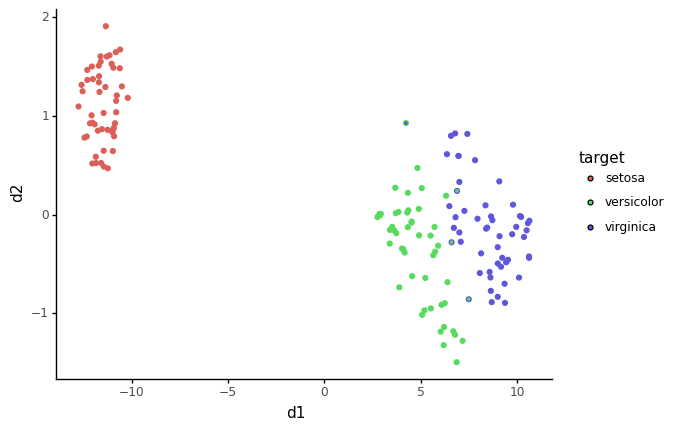

In [338]:
print(
    ggplot(tsne_df, aes(x = 'd1', y = 'd2', colour='prediction', fill='target')) +
        theme_classic() +
        geom_point() +
        guides(colour=False)
)

#### Visualize gradient boosted tree

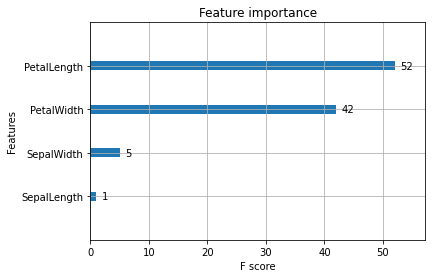

In [256]:
gb.plot_importance(gbc)
pl.show()

In [352]:
rfc_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rfc.feature_importances_,
    'sd': np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0),
})
rfc_df

,feature,importance,sd
0,SepalLength,0.121732,0.151919
1,SepalWidth,0.037519,0.062673
2,PetalLength,0.427373,0.273185
3,PetalWidth,0.413376,0.286593


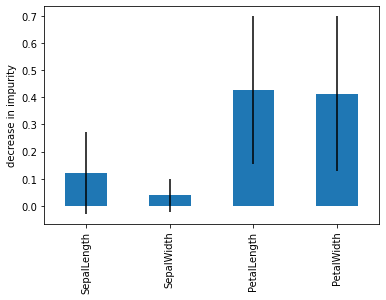

In [363]:
ax = rfc_df.importance.plot.bar(yerr=rfc_df.sd)
ax.set_xticklabels(feature_names)
ax.set_ylabel('decrease in impurity')
pl.show()